<a href="https://colab.research.google.com/github/martinGalajdaSchool/object-detection/blob/master/InferenceSpeedBenchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

THESIS_RESOURCES_DIR = f'/content/drive/My Drive/object-detection-thesis'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#  First time setup - DO ONLY ONCE in you Google Drive 

Let's change directory to the project folder and clone repo.

In [0]:
! mkdir -p '/content/drive/My Drive/object-detection-thesis'
%cd '/content/drive/My Drive/object-detection-thesis'
! rm -r '/content/drive/My Drive/object-detection-thesis/object-detection'
! git clone https://github.com/martinGalajdaSchool/object-detection.git

! ls

First, let's compile protobufs (needed for FasterRCNN inference):

In [0]:
%cd '/content/drive/My Drive/object-detection-thesis/object-detection/models/faster_rcnn_inception_resnet_v2_oid_v4/protos'
!  protoc -I=. --python_out=. ./string_int_label_map.proto

/content/drive/My Drive/object-detection-thesis/object-detection/models/faster_rcnn_inception_resnet_v2_oid_v4/protos


# Setup

Let's change directory to project repo root folder.

Make sure we have latest sources...

In [0]:
%cd '/content/drive/My Drive/object-detection-thesis/object-detection'
! pwd
! git pull origin master

/content/drive/My Drive/object-detection-thesis/object-detection
/content/drive/My Drive/object-detection-thesis/object-detection
From https://github.com/martinGalajdaSchool/object-detection
 * branch            master     -> FETCH_HEAD
Already up to date.


**Let's include and construct detectors**

# Construct Faster R-CNN

In [0]:
from models.faster_rcnn_inception_resnet_v2_oid_v4.object_detector import ObjectDetector as FasterRCNNObjectDetector

PATH_TO_FASTER_RCNN_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/faster_rcnn"
PATH_TO_FASTER_RCNN_INFERENCE_GRAPH = f'{PATH_TO_FASTER_RCNN_RESOURCES}/frozen_inference_graph.pb'
PATH_TO_FASTER_RCNN_CLASSES = f'{PATH_TO_FASTER_RCNN_RESOURCES}/oid_v4_label_map.pbtxt'

faster_rcnn_detector = FasterRCNNObjectDetector(
    path_to_frozen_graph=PATH_TO_FASTER_RCNN_INFERENCE_GRAPH,
    path_to_classes=PATH_TO_FASTER_RCNN_CLASSES,
    use_gpu=True,
    log_device_placement=False,
)

# Construct YOLOv3 CPU
- with inference head in numpy

In [0]:
from models.yolov3.cpu_head.object_detector import ObjectDetector as YOLOV3ObjectDetectorCPUHead

PATH_TO_YOLOV3_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/yolov3"
PATH_TO_YOLOV3_MODEL = f'{PATH_TO_YOLOV3_RESOURCES}/model.h5'
PATH_TO_YOLOV3_CLASSES = f'{PATH_TO_YOLOV3_RESOURCES}/openimages.names'

yolov3_object_detector_cpu_head = YOLOV3ObjectDetectorCPUHead(
    path_to_model=PATH_TO_YOLOV3_MODEL,
    path_to_classes=PATH_TO_YOLOV3_CLASSES
)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Construct YOLOv3 GPU v1
- with inference head in TensorFlow, non-max supression in numpy



In [0]:
from models.yolov3.gpu_head_v1.object_detector import ObjectDetector as YOLOV3ObjectDetectorGPU

PATH_TO_YOLOV3_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/yolov3"
PATH_TO_YOLOV3_MODEL = f'{PATH_TO_YOLOV3_RESOURCES}/model.h5'
PATH_TO_YOLOV3_CLASSES = f'{PATH_TO_YOLOV3_RESOURCES}/openimages.names'

yolov3_object_detector_gpu_v1 = YOLOV3ObjectDetectorGPU(
    path_to_model=PATH_TO_YOLOV3_MODEL,
    path_to_classes=PATH_TO_YOLOV3_CLASSES
)

# Construct YOLOv3 GPU v2
- with inference head in TensorFlow, non-max supression in TensorFlow


In [0]:
from models.yolov3.gpu_head_v2.object_detector import ObjectDetector as YOLOV3ObjectDetectorGPUV2
PATH_TO_YOLOV3_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/yolov3"
PATH_TO_YOLOV3_MODEL = f'{PATH_TO_YOLOV3_RESOURCES}/model.h5'
PATH_TO_YOLOV3_CLASSES = f'{PATH_TO_YOLOV3_RESOURCES}/openimages.names'

yolov3_object_detector_gpu_v2 = YOLOV3ObjectDetectorGPUV2(
  path_to_model=PATH_TO_YOLOV3_MODEL,
  path_to_classes=PATH_TO_YOLOV3_CLASSES,
  log_device_placement=False,
  verbose=False
)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Took 37.84715414047241 seconds to construct network.


# Prepare TPU environment

In [0]:
import tensorflow as tf
import os

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.69.152.186:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 13374392618011621163)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11053867239752514222)
INFO:tensorflow:**

# Utility functions for benchmarking and plotting results

Let's load testing image and create benchmarking function

In [0]:
from utils.image import load_pil_image_from_file
from typing import List, Any
import numpy as np
import time
from models.data.base_object_detector import BaseObjectDetector


PATH_TO_TEST_IMAGE = "/content/drive/My Drive/object-detection-thesis/test-images/p_nriKHUVlZ9MkDEoYj8Z.jpg"

BASE_PATH_TO_BENCHMARK_IMAGES = '/content/drive/My Drive/object-detection-thesis/benchmark-images'
BENCHMARK_IMAGE_NAMES = [
    'earth_apollo17_3002_3000.jpg',
    'horse_284_177.jpeg',
    'woman_blonde_512_512.jpg'
]
BENCHMARK_IMAGE_FULL_NAMES = list(map(lambda filename: f'{BASE_PATH_TO_BENCHMARK_IMAGES}/{filename}', BENCHMARK_IMAGE_NAMES))


def make_banchmark_detector(path_to_images: List[str], image_names: List[str]):
  path_to_img_map = {}
  for path_to_img in path_to_images:
    _, img_np = load_pil_image_from_file(path_to_img)
    
    # fix grayscale image
    if len(img_np.shape) == 2:
      img_np = np.stack((img_np,) * 3, axis=-1)

    path_to_img_map[path_to_img] = img_np
    
  
  def _benchmark_detector(detector: BaseObjectDetector, num_of_iterations: int):
    _ = detector.infer_object_detections_on_loaded_image(path_to_img_map[path_to_images[0]])

    
    avg_times = []
    img_boxes_detected = {}

    all_inference_times = {}
    for idx, path_to_img in enumerate(path_to_images):
      img_np = path_to_img_map[path_to_img]
      img_shape = img_np.shape[:2]
      print(f'Starting to benchmark on image: {image_names[idx]}.')

      inference_times_for_image = []
      start = time.time()
      for i in range(num_of_iterations):
        start_inference = time.time()
        detected_bboxes, _, _ = detector.infer_object_detections_on_loaded_image(img_np)
        end_inference = time.time()
        inference_times_for_image.append(end_inference - start_inference)

      end = time.time()
      avg_time = (end - start) / num_of_iterations
      
      all_inference_times[image_names[idx]] = inference_times_for_image
      img_boxes_detected[image_names[idx]] = len(detected_bboxes)

      avg_times.append([path_to_img, image_names[idx], f'{img_shape[1]}, {img_shape[0]}', f'{avg_time} s',  avg_time, len(detected_bboxes)])
      
    return avg_times, all_inference_times, img_boxes_detected
   
  return _benchmark_detector

def print_benchmark_results(detector: Any, avg_times_res: List[List[Any]]):
  print(f'*** BENCHMARK RESULTS FOR {detector.name} ***')
  
  for avg_time_res in avg_times_res:
    _, image_name, img_shape, avg_time_str, _, detected_bboxes = avg_time_res
    print(f'{image_name} - ({img_shape}) - {avg_time_str} - {detected_bboxes} boxes detected.')

  overal_avg_speed = sum(map(lambda res: res[4], avg_times_res)) / len(avg_times_res)
  print(f'Overal average inference speed: {overal_avg_speed}s.')
  
  print(f'*** END ***')

  
benchmark_detector = make_banchmark_detector(BENCHMARK_IMAGE_FULL_NAMES, BENCHMARK_IMAGE_NAMES)

In [0]:
import csv
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt

ROOT_OUTPUT_PATH_BENCHMARK_RESULTS = "/content/drive/My Drive/object-detection-thesis/inference-speed-benchmarks-results"


def write_csv_rows(filepath: str, rows: list, *, append_file: bool = False):
  mode = 'w' if not append_file else 'a'
  with open(filepath, mode) as csvfile:
      writer = csv.writer(csvfile)
      for row in rows:
        writer.writerow(row)


def plot_benchmark_results_and_write_to_csv_file(
    *,
    model_name,
    results
):
  avg_times, all_inference_times_by_image_name, num_detected_bboxes_by_image_name = results
  sns.set(rc={ 'figure.figsize': (15, 15 )}, )
  sns.set(font_scale=1.7)

  plot_data = []

  OUTPUT_PATH_GRAPH = f"/content/drive/My Drive/object-detection-thesis/plots/{model_name}.png"

  for image_name in all_inference_times_by_image_name.keys():
    vals = all_inference_times_by_image_name[image_name]
    boxes_detected = num_detected_bboxes_by_image_name[image_name]
    plot_data += list(map(lambda inf_speed: [image_name, inf_speed, boxes_detected, model_name], vals))

  columns = ["image", "inference speed (s)", "boxes detected", "model name"]
  plot_dataframe = pd.DataFrame(plot_data, columns=["image", "inference speed (s)", "boxes detected", "model name"])

  fig, ax = plt.subplots()
  sns_plot = sns.boxplot(x="image", y="inference speed (s)",  data=plot_dataframe, ax=ax)
  sns_plot.set(ylim=(0, None))
  # sns_plot.set_title(model_name)

  fig.savefig(OUTPUT_PATH_GRAPH)

  csv_data = [columns]
  csv_data += plot_data
  write_csv_rows(f'{ROOT_OUTPUT_PATH_BENCHMARK_RESULTS}/results_{model_name}.csv', csv_data)

# **Benchmarks for YOLOv3 (with non-max suppression in TensorFlow) on CPU**


In [0]:
yolov3_gpu_head_v2_on_cpu_results = benchmark_detector(yolov3_object_detector_gpu_v2, 10)
print_benchmark_results(yolov3_object_detector_gpu_v2, yolov3_gpu_head_v2_on_cpu_results[0])

Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Starting to benchmark on image: horse_284_177.jpeg.
Starting to benchmark on image: woman_blonde_512_512.jpg.
*** BENCHMARK RESULTS FOR YOLOv3 ***
earth_apollo17_3002_3000.jpg - (3000, 3002) - 3.917899489402771 s - 0 boxes detected.
horse_284_177.jpeg - (284, 177) - 3.8476473093032837 s - 1 boxes detected.
woman_blonde_512_512.jpg - (512, 512) - 3.851556420326233 s - 3 boxes detected.
Overal average inference speed: 3.872367739677429s.
*** END ***


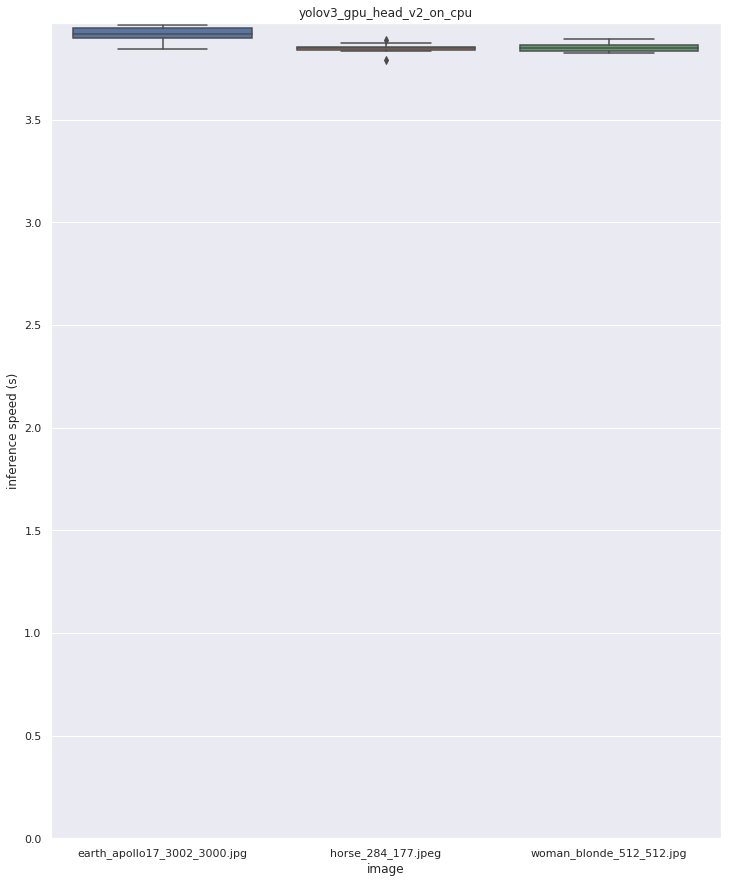

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="yolov3_gpu_head_v2_on_cpu",
    results=yolov3_gpu_head_v2_on_cpu_results
)

# **Benchmarks for YOLOv3 (with non-max suppression in TensorFlow) on GPU**

In [0]:
yolov3_gpu_head_v2_on_gpu_results = benchmark_detector(yolov3_object_detector_gpu_v2, 100)
print_benchmark_results(yolov3_object_detector_gpu_v2, yolov3_gpu_head_v2_on_gpu_results[0])

Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Starting to benchmark on image: horse_284_177.jpeg.
Starting to benchmark on image: woman_blonde_512_512.jpg.
*** BENCHMARK RESULTS FOR YOLOv3 ***
earth_apollo17_3002_3000.jpg - (3000, 3002) - 0.32878761053085326 s - 0 boxes detected.
horse_284_177.jpeg - (284, 177) - 0.2536811876296997 s - 1 boxes detected.
woman_blonde_512_512.jpg - (512, 512) - 0.26109469890594483 s - 3 boxes detected.
Overal average inference speed: 0.28118783235549927s.
*** END ***


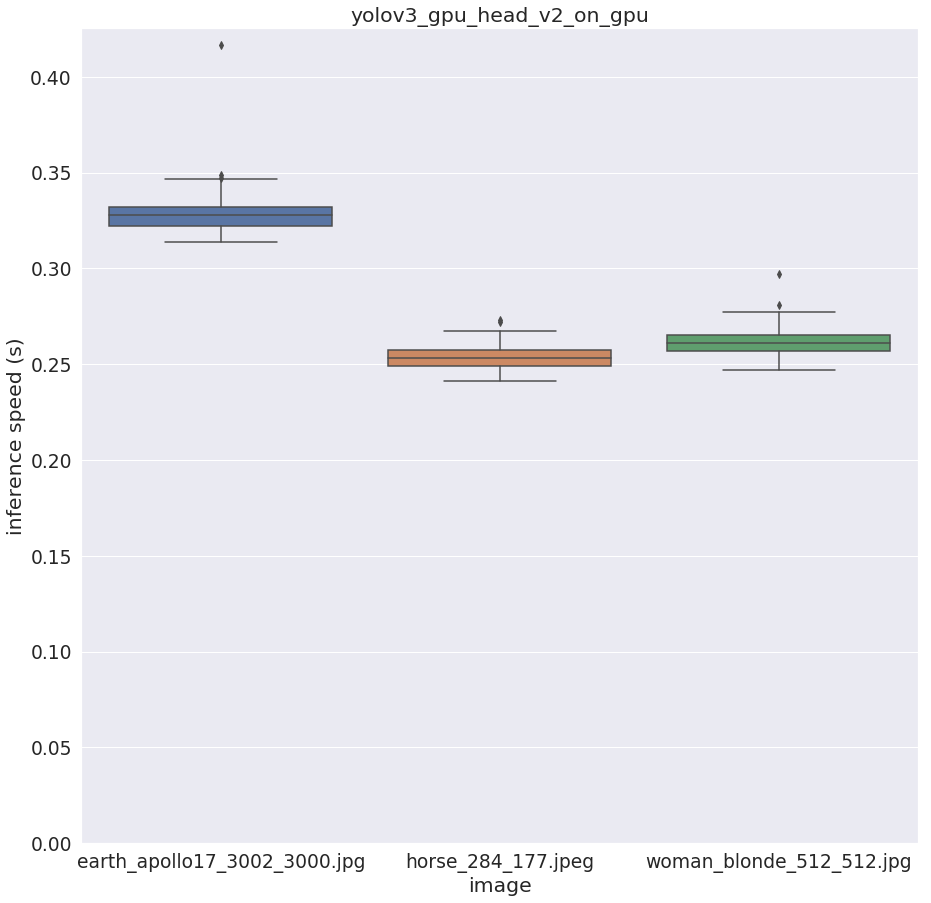

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="yolov3_gpu_head_v2_on_gpu",
    results=yolov3_gpu_head_v2_on_gpu_results
)

# Benchmarks for YOLOv3 (with non-max suppression in TensorFlow) on TPU 

In [0]:
import tensorflow as tf

PATH_TO_YOLOV3_MODEL = f'{PATH_TO_YOLOV3_RESOURCES}/model.h5'

with strategy.scope():
  yolov3_object_detector_tpu = YOLOV3ObjectDetectorGPUHeadv2(
    path_to_model=PATH_TO_YOLOV3_MODEL,
    path_to_classes=PATH_TO_YOLOV3_CLASSES,
    log_device_placement=False,
    verbose=False
  )


  yolov3_tpu_results = benchmark_detector(yolov3_object_detector_tpu, 100)
  print_benchmark_results(yolov3_object_detector_tpu, yolov3_tpu_results[0])



Took 29.88048267364502 seconds to construct network.
Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Starting to benchmark on image: horse_284_177.jpeg.
Starting to benchmark on image: woman_blonde_512_512.jpg.
*** BENCHMARK RESULTS FOR YOLOv3 ***
earth_apollo17_3002_3000.jpg - (3000, 3002) - 0.44209986209869384 s - 0 boxes detected.
horse_284_177.jpeg - (284, 177) - 0.3645665383338928 s - 1 boxes detected.
woman_blonde_512_512.jpg - (512, 512) - 0.37098734140396117 s - 3 boxes detected.
Overal average inference speed: 0.39255124727884927s.
*** END ***


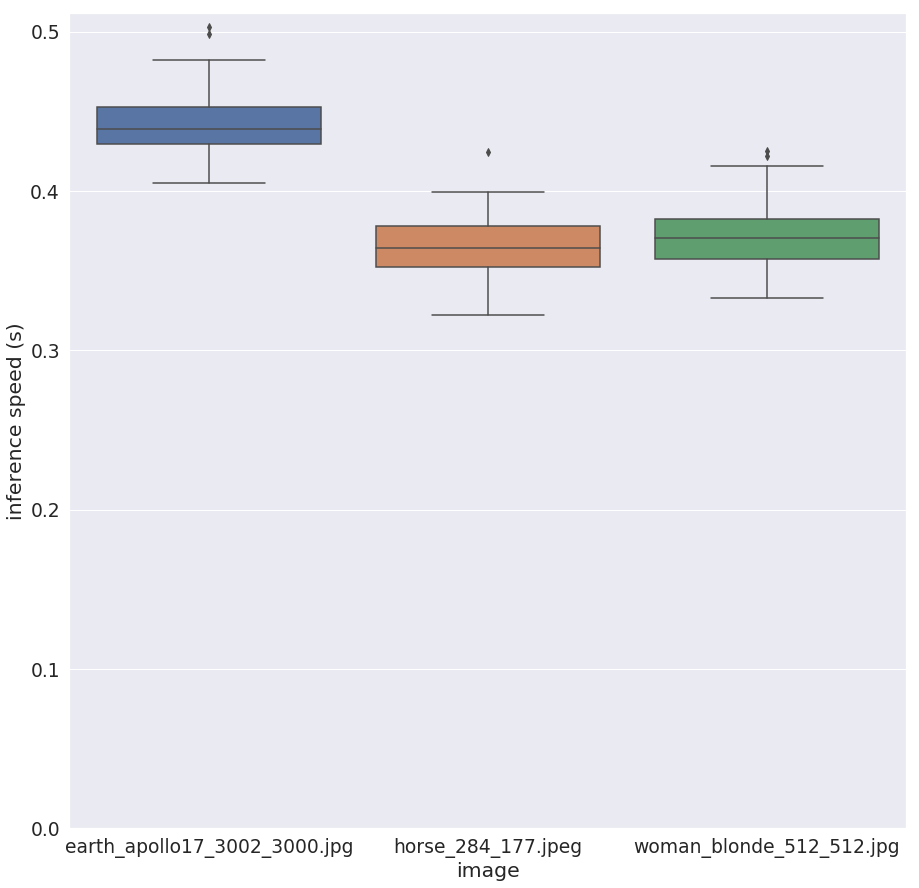

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="yolov3_gpu_head_v2_on_tpu",
    results=yolov3_tpu_results
)

# Benchmarks for Faster R-CNN on GPU

In [0]:
faster_rcnn_results_on_gpu = benchmark_detector(faster_rcnn_detector, 100)
print_benchmark_results(faster_rcnn_detector, faster_rcnn_results_on_gpu[0])

Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Starting to benchmark on image: horse_284_177.jpeg.
Starting to benchmark on image: woman_blonde_512_512.jpg.
*** BENCHMARK RESULTS FOR FasterRCNN ***
earth_apollo17_3002_3000.jpg - (3000, 3002) - 1.141931722164154 s - 1 boxes detected.
horse_284_177.jpeg - (284, 177) - 1.38911408662796 s - 1 boxes detected.
woman_blonde_512_512.jpg - (512, 512) - 1.1232755923271178 s - 3 boxes detected.
Overal average inference speed: 1.2181071337064104s.
*** END ***


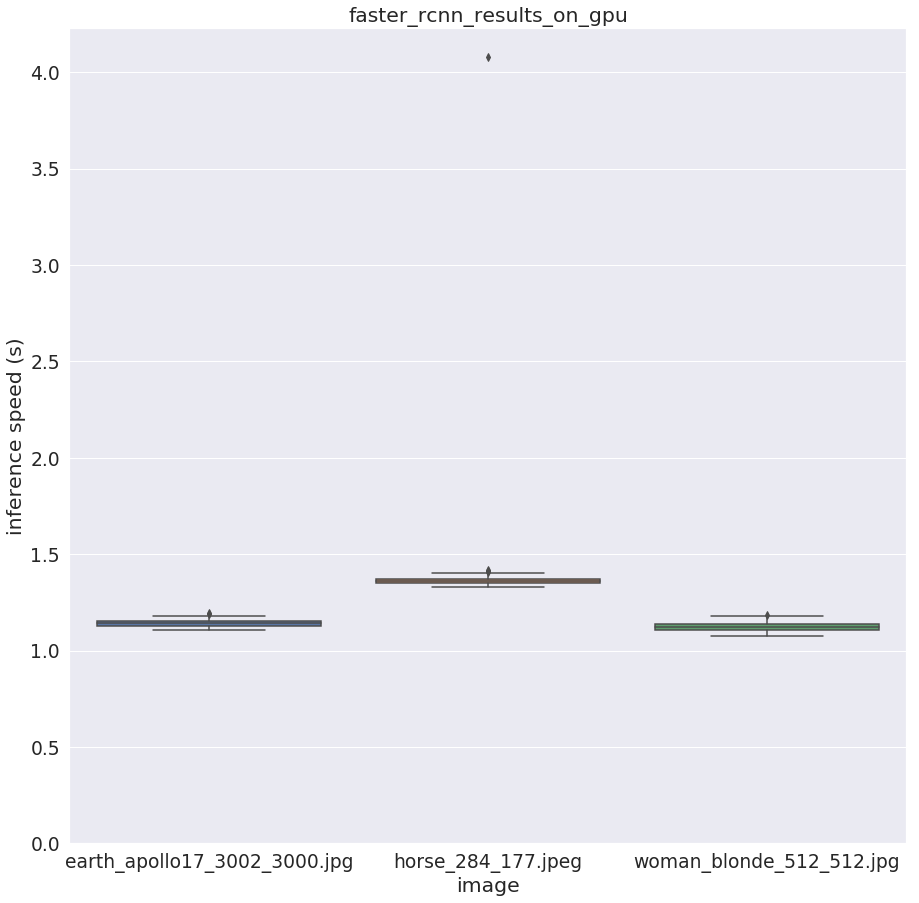

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="faster_rcnn_results_on_gpu",
    results=faster_rcnn_results_on_gpu
)

# Benchmarks for Faster R-CNN on CPU

In [0]:
faster_rcnn_results_on_cpu = benchmark_detector(faster_rcnn_detector, 10)
print_benchmark_results(faster_rcnn_detector, faster_rcnn_results_on_cpu[0])

Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Starting to benchmark on image: horse_284_177.jpeg.
Starting to benchmark on image: woman_blonde_512_512.jpg.
*** BENCHMARK RESULTS FOR FasterRCNN ***
earth_apollo17_3002_3000.jpg - (3000, 3002) - 14.635195231437683 s - 1 boxes detected.
horse_284_177.jpeg - (284, 177) - 18.88583550453186 s - 1 boxes detected.
woman_blonde_512_512.jpg - (512, 512) - 14.612132573127747 s - 3 boxes detected.
Overal average inference speed: 16.044387769699096s.
*** END ***


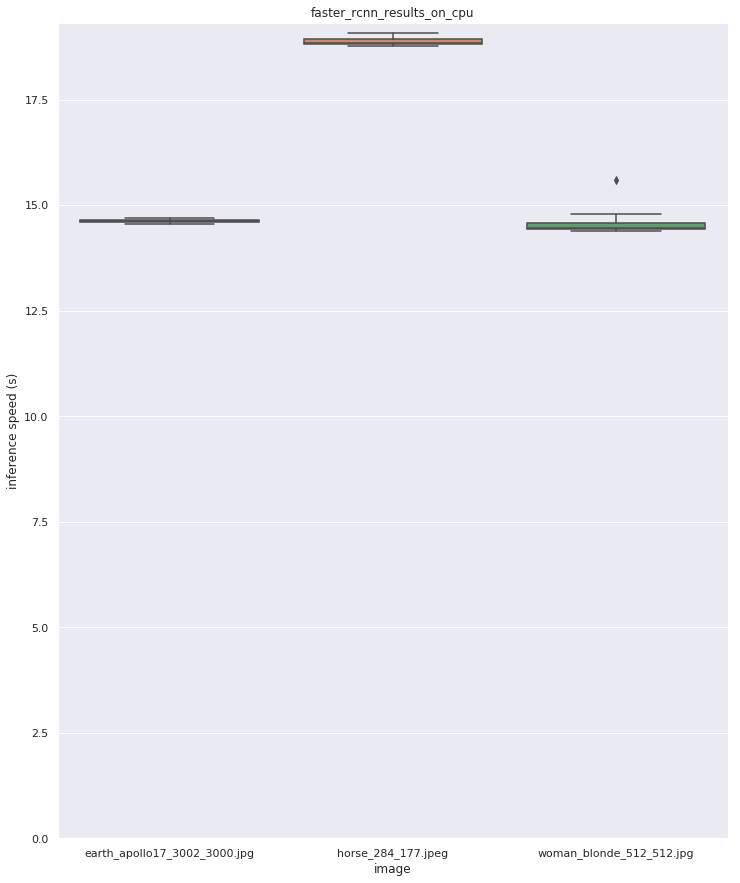

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="faster_rcnn_results_on_cpu",
    results=faster_rcnn_results_on_cpu
)

# Benchmarks for YOLOv3 (with non-max suppression in numpy) on GPU

In [0]:
yolov3_gpu_head_v1_on_gpu_results = benchmark_detector(yolov3_object_detector_gpu_v1, 100)
print_benchmark_results(yolov3_object_detector_gpu_v1, yolov3_gpu_head_v1_on_gpu_results[0])

Took 0.27657556533813477 seconds to construct network.
Took 8.883634090423584 seconds to infer outputs in session.
Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Took 0.2734529972076416 seconds to construct network.
Took 11.23812222480774 seconds to infer outputs in session.
Took 0.2651398181915283 seconds to construct network.
Took 11.825292825698853 seconds to infer outputs in session.
Took 0.27567100524902344 seconds to construct network.
Took 9.167628765106201 seconds to infer outputs in session.
Took 0.2689204216003418 seconds to construct network.
Took 11.152594089508057 seconds to infer outputs in session.
Took 0.2693002223968506 seconds to construct network.
Took 9.867393970489502 seconds to infer outputs in session.
Took 0.2649970054626465 seconds to construct network.
Took 9.44000792503357 seconds to infer outputs in session.
Took 0.2720909118652344 seconds to construct network.
Took 13.883984327316284 seconds to infer outputs in session.
Took 0.263549089431762

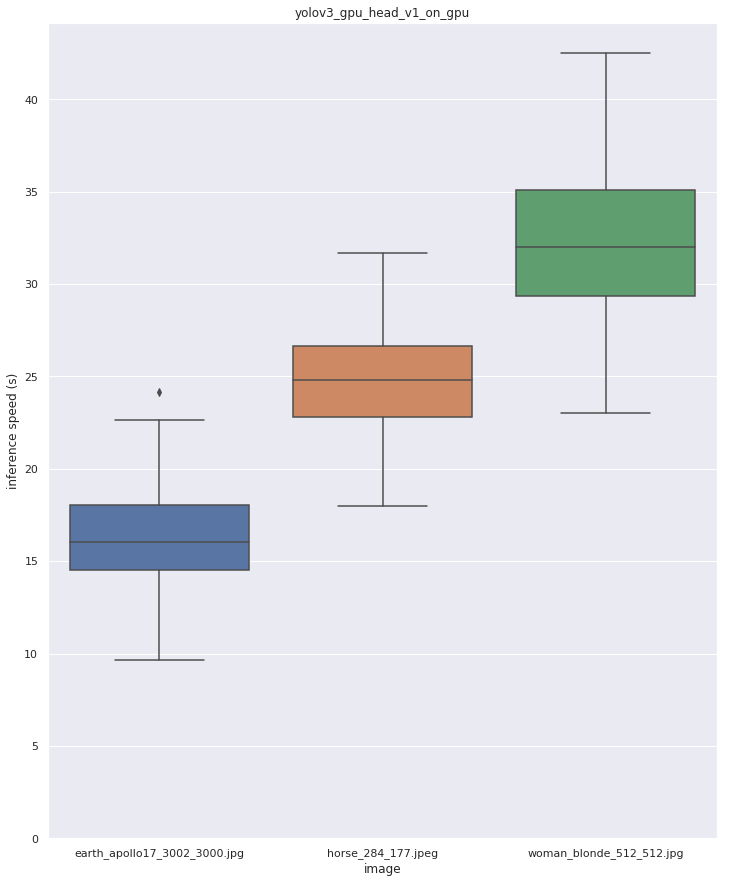

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="yolov3_gpu_head_v1_on_gpu",
    results=yolov3_gpu_head_v1_on_gpu_results
)

# Benchmarks for YOLOv3 (with non-max suppression in numpy) on CPU

In [0]:
yolov3_gpu_head_v1_on_cpu_results = benchmark_detector(yolov3_object_detector_gpu_v1, 10)
print_benchmark_results(yolov3_object_detector_gpu_v1, yolov3_gpu_head_v1_on_cpu_results[0])

Took 0.2795083522796631 seconds to construct network.
Took 12.935075521469116 seconds to infer outputs in session.
Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Took 0.25943851470947266 seconds to construct network.
Took 13.428674936294556 seconds to infer outputs in session.
Took 0.24801301956176758 seconds to construct network.
Took 12.4640474319458 seconds to infer outputs in session.
Took 0.25767087936401367 seconds to construct network.
Took 13.277205228805542 seconds to infer outputs in session.
Took 0.2594106197357178 seconds to construct network.
Took 13.244008541107178 seconds to infer outputs in session.
Took 0.27483606338500977 seconds to construct network.
Took 13.412510395050049 seconds to infer outputs in session.
Took 0.27181434631347656 seconds to construct network.
Took 13.341259717941284 seconds to infer outputs in session.
Took 0.2562680244445801 seconds to construct network.
Took 14.669529676437378 seconds to infer outputs in session.
Took 0.25796914

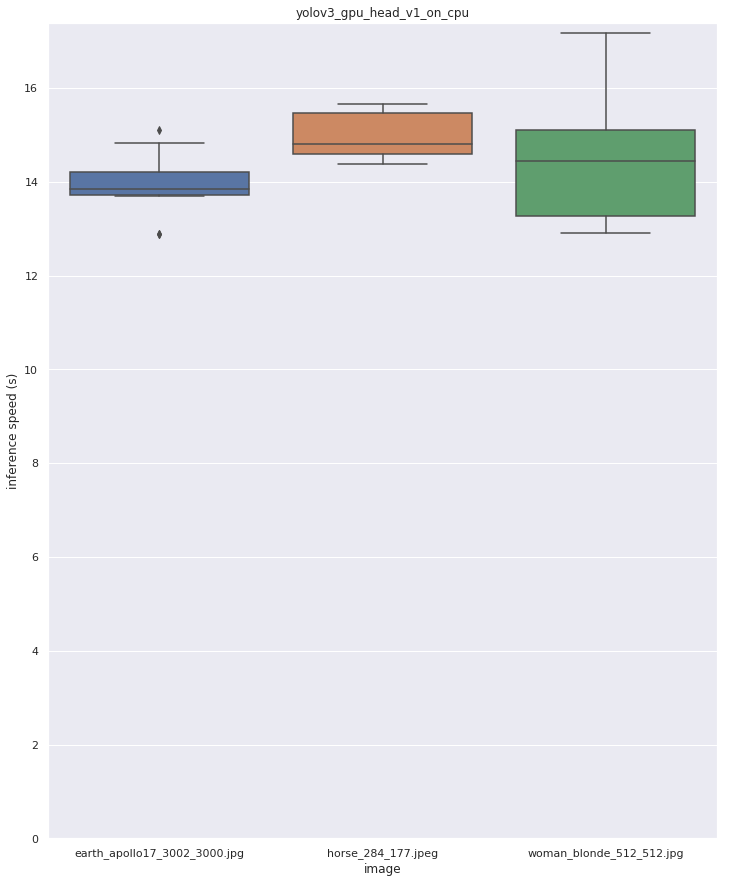

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="yolov3_gpu_head_v1_on_cpu",
    results=yolov3_gpu_head_v1_on_cpu_results
)

# Benchmarks for YOLOv3 (with non-max suppression in Numpy) on TPU

In [0]:
from models.yolov3.gpu_head_v1.object_detector import ObjectDetector as YOLOV3ObjectDetectorGPU

PATH_TO_YOLOV3_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/yolov3"
PATH_TO_YOLOV3_MODEL = f'{PATH_TO_YOLOV3_RESOURCES}/model.h5'
PATH_TO_YOLOV3_CLASSES = f'{PATH_TO_YOLOV3_RESOURCES}/openimages.names'

with strategy.scope():
  yolov3_object_detector_gpu_v1 = YOLOV3ObjectDetectorGPU(
    path_to_model=PATH_TO_YOLOV3_MODEL,
    path_to_classes=PATH_TO_YOLOV3_CLASSES,
    gpu_allow_growth=False
  )

  yolov3_gpu_head_v1_on_tpu_results = benchmark_detector(yolov3_object_detector_gpu_v1, 100)
  print_benchmark_results(yolov3_object_detector_gpu_v1, yolov3_gpu_head_v1_on_tpu_results[0])

Using TensorFlow backend.


Took 0.2193286418914795 seconds to construct network.
Took 3.850081205368042 seconds to infer outputs in session.
Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Took 0.22452783584594727 seconds to construct network.
Took 4.0203776359558105 seconds to infer outputs in session.
Took 0.2306520938873291 seconds to construct network.
Took 4.092411994934082 seconds to infer outputs in session.
Took 0.2257096767425537 seconds to construct network.
Took 4.199424982070923 seconds to infer outputs in session.
Took 0.22498583793640137 seconds to construct network.
Took 4.46580171585083 seconds to infer outputs in session.
Took 0.2237396240234375 seconds to construct network.
Took 4.454912424087524 seconds to infer outputs in session.
Took 0.22684907913208008 seconds to construct network.
Took 4.219798564910889 seconds to infer outputs in session.
Took 0.22614502906799316 seconds to construct network.
Took 4.450742244720459 seconds to infer outputs in session.
Took 0.221990108489990

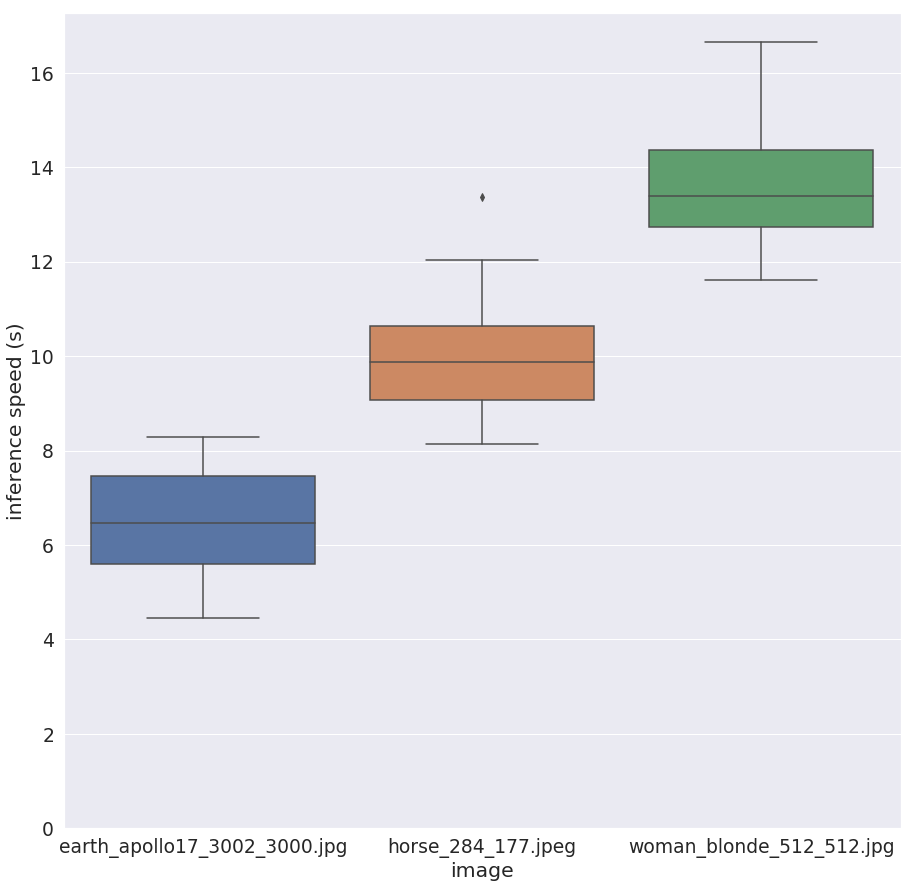

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="yolov3_gpu_head_v1_on_tpu",
    results=yolov3_gpu_head_v1_on_tpu_results
)

# Benchmarks for Faster R-CNN on TPU

In [0]:
import tensorflow as tf
from models.faster_rcnn_inception_resnet_v2_oid_v4.object_detector import ObjectDetector as FasterRCNNObjectDetector

PATH_TO_FASTER_RCNN_RESOURCES = "/content/drive/My Drive/THESIS_RESOURCES/faster_rcnn"
PATH_TO_FASTER_RCNN_INFERENCE_GRAPH = f'{PATH_TO_FASTER_RCNN_RESOURCES}/frozen_inference_graph.pb'
PATH_TO_FASTER_RCNN_CLASSES = f'{PATH_TO_FASTER_RCNN_RESOURCES}/oid_v4_label_map.pbtxt'

with strategy.scope():
  faster_rcnn_detector = FasterRCNNObjectDetector(
      path_to_frozen_graph=PATH_TO_FASTER_RCNN_INFERENCE_GRAPH,
      path_to_classes=PATH_TO_FASTER_RCNN_CLASSES,
      use_gpu=True,
      log_device_placement=False,
  )

  faster_rcnn_detector_tpu_results = benchmark_detector(faster_rcnn_detector, 100)
  print_benchmark_results(faster_rcnn_detector, faster_rcnn_detector_tpu_results[0])



Starting to benchmark on image: earth_apollo17_3002_3000.jpg.
Starting to benchmark on image: horse_284_177.jpeg.
Starting to benchmark on image: woman_blonde_512_512.jpg.
*** BENCHMARK RESULTS FOR FasterRCNN ***
earth_apollo17_3002_3000.jpg - (3000, 3002) - 14.283782918453216 s - 1 boxes detected.
horse_284_177.jpeg - (284, 177) - 18.547305092811584 s - 1 boxes detected.
woman_blonde_512_512.jpg - (512, 512) - 14.306312851905822 s - 3 boxes detected.
Overal average inference speed: 15.712466954390207s.
*** END ***


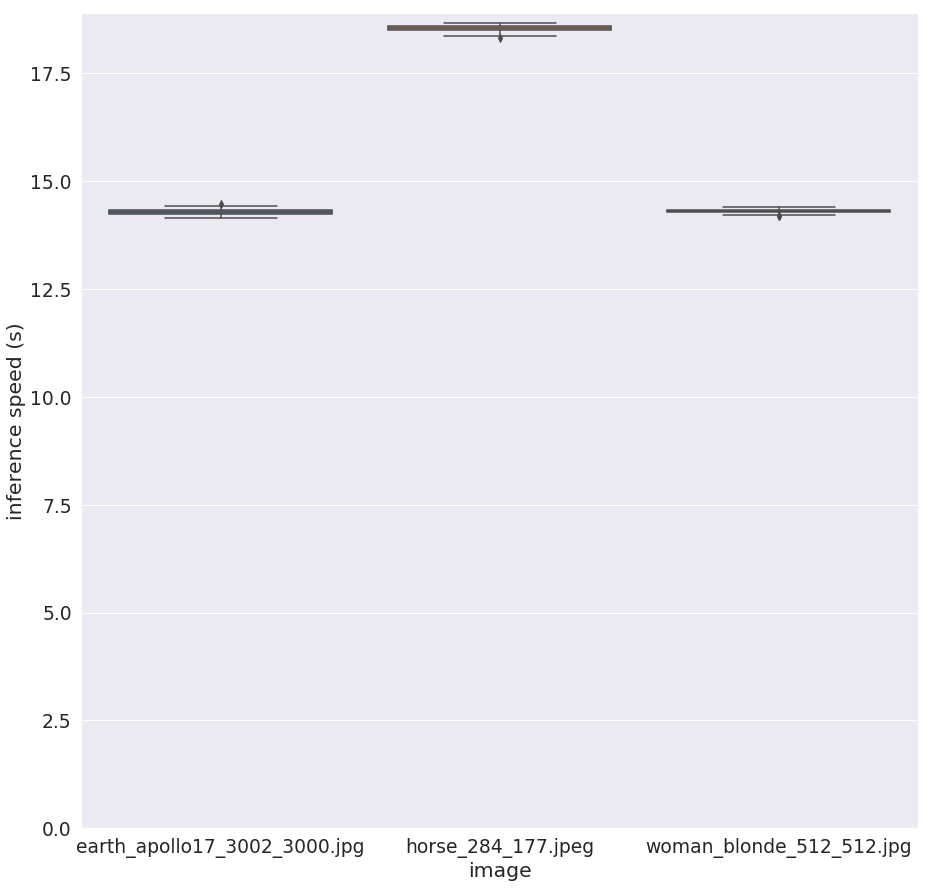

In [0]:
plot_benchmark_results_and_write_to_csv_file(
    model_name="faster_rcnn_on_tpu",
    results=faster_rcnn_detector_tpu_results
)

# Construct plots from CSV files containing benchmark results

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1038: UserWarning: Bad val "vertical" on line #15
	"xtick.alignment: vertical
"
	in file "/content/drive/My Drive/object-detection-thesis/object-detection/plotting.mplstyle"
	Key xtick.alignment: Unrecognized alignment string 'vertical': valid strings are ['center', 'top', 'bottom', 'baseline', 'center_baseline']
  (val, error_details, msg))
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


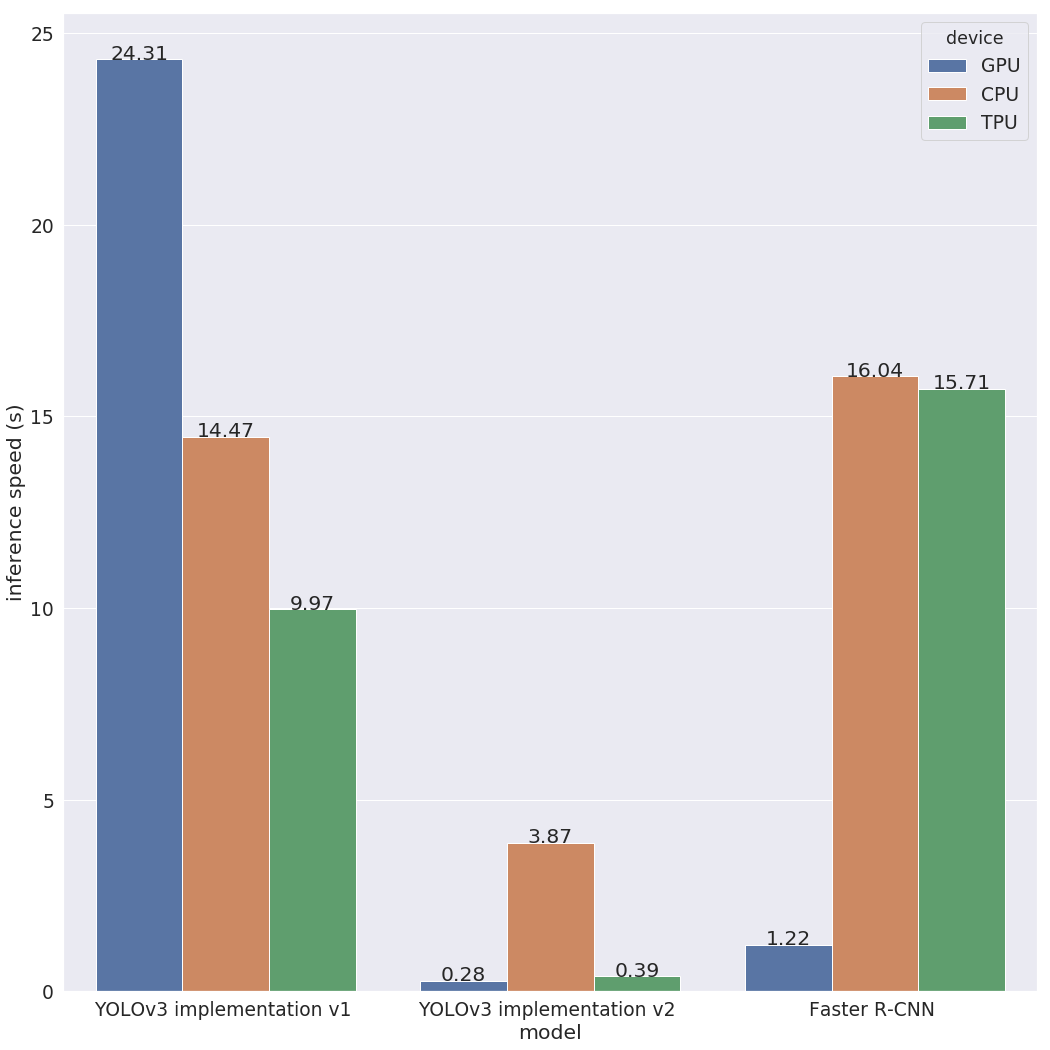

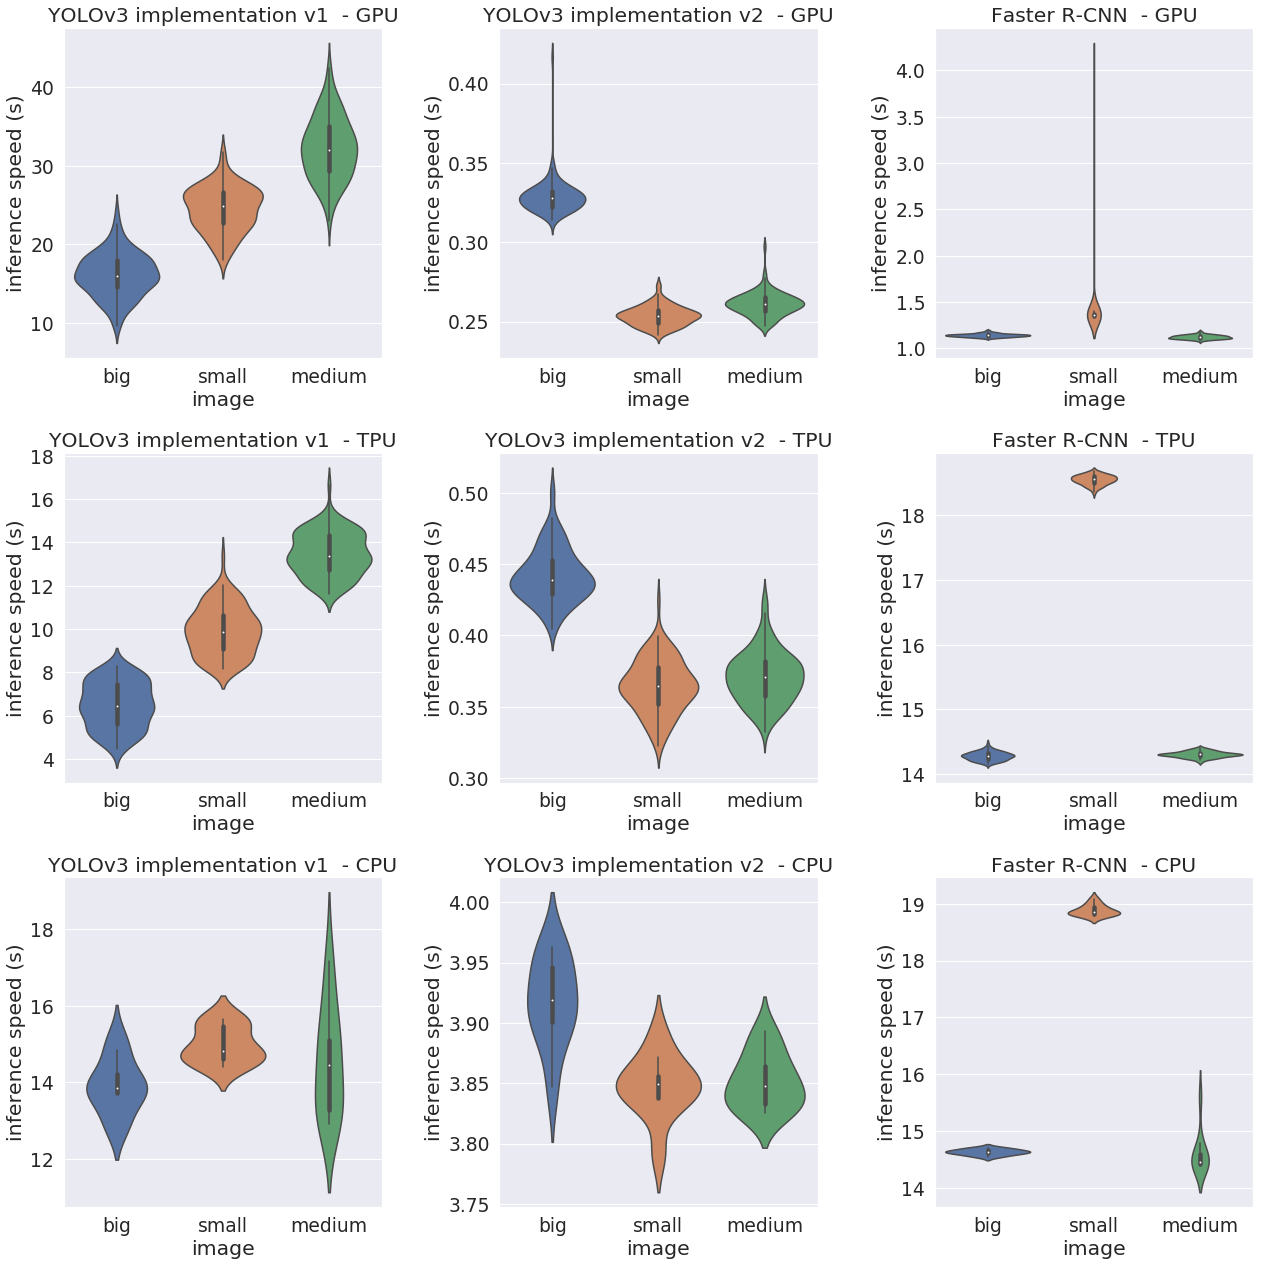

In [0]:
import os
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

PATH_TO_OUTPUT_CSV_FILES = f'{THESIS_RESOURCES_DIR}/inference-speed-benchmarks-results'
OUTPUT_PATH_PLOT = f"/content/drive/My Drive/object-detection-thesis/plots/inference_speed_comparison.png"
OUTPUT_PATH_PLOT_BY_IMAGES = f"/content/drive/My Drive/object-detection-thesis/plots/inference_speed_comparison_by_images.png"

plt.style.use('/content/drive/My Drive/object-detection-thesis/object-detection/plotting.mplstyle')

def collect_avg_inference_times_by_model(path_to_out_dir: str):
  files_in_dir = os.listdir(path_to_out_dir)
  COLUMNS = ['image', 'inference speed (s)', 'boxes detected', 'model name']

  inference_times_by_model = defaultdict(list)

  for file_in_dir in files_in_dir:
    target_path = os.path.join(path_to_out_dir, file_in_dir)
    data_for_plot = []
    with open(target_path, 'r') as csv_file:
      csv_reader = csv.DictReader(csv_file)

      for row in csv_reader:
        row_data = list(map(lambda col: row[col], COLUMNS))
        data_for_plot.append(row_data)

        model_name = row['model name'].replace("_", " ")
        inference_speed = float(row['inference speed (s)'])

        inference_times_by_model[model_name].append(inference_speed)

  return inference_times_by_model


def format_model_name(
    model_name: str
):
  return model_name.replace("_", " ") \
    .replace("faster rcnn", "Faster R-CNN") \
    .replace("yolov3", "YOLOv3") \
    .replace("on cpu", "") \
    .replace("on tpu", "") \
    .replace("on gpu", "") \
    .replace("results", "") \
    .replace("gpu head", "implementation") \
    .replace("  ", " ")

def get_device_from_model_name(model_name):
  if "on cpu" in model_name:
    return "CPU"
  elif "on gpu" in model_name:
    return "GPU"
  else:
    return "TPU"


def format_img_name(img_name):
  if "earth" in img_name:
    return "big"
  elif "512_512" in img_name:
    return "medium"
  else:
    return "small"


def collect_measured_inference_times_by_models(path_to_out_dir: str):
  files_in_dir = os.listdir(path_to_out_dir)
  COLUMNS = ['image', 'inference speed (s)', 'boxes detected', 'model name']

  inference_times_by_model = defaultdict(list)

  all_inference_measurements = {
      'device': [],
  }
  for col in COLUMNS:
    all_inference_measurements[col] = []

  for file_in_dir in files_in_dir:
    target_path = os.path.join(path_to_out_dir, file_in_dir)
    with open(target_path, 'r') as csv_file:
      csv_reader = csv.DictReader(csv_file)

      for row in csv_reader:
        device = get_device_from_model_name(row['model name'].replace("_", " "))
        row['inference speed (s)'] = float(row['inference speed (s)'])
        row['model name'] = format_model_name(row['model name'])
        row['image'] = format_img_name(row['image'])

        row_cols = COLUMNS + ['device']
        row['device'] = device

        for col in row_cols:
          all_inference_measurements[col].append(row[col])

  return pd.DataFrame.from_dict(all_inference_measurements)

def plot_box_plots_inference_times_for_models(dataframe_for_plot, output_path_plot: str):
  # plt.style.use('/content/drive/My Drive/object-detection-thesis/object-detection/plotting.mplstyle')


  devices = list(set(list(dataframe_for_plot['device'])))
  model_names = list(set(list(dataframe_for_plot['model name'])))
  fig, axis = plt.subplots(len(devices), len(model_names), figsize=(18, 18))


  dataframes = {}
  for idx_axis_one, device_name in enumerate(devices):
    if not idx_axis_one in dataframes:
      dataframes[idx_axis_one] = {}

    for idx_axis_two, model_name in enumerate(model_names):
      picked_by_device_name = dataframe_for_plot[dataframe_for_plot['device'] == device_name]
      picked_by_model_Name = picked_by_device_name[picked_by_device_name['model name'] == model_name]
      dataframes[idx_axis_one][idx_axis_two] = picked_by_model_Name

  for idx, axes in enumerate(axis):
    for idx2, ax in enumerate(axes):
      # if idx == 0 and idx2 == 0:
      #   ax.remove()
      if len (dataframes[idx][idx2]) > 0:
        sns_plot = sns.violinplot(x="image", y="inference speed (s)", data=dataframes[idx][idx2], ax=ax)
        sns_plot.set(title=f'{model_names[idx2]} - {devices[idx]}')
      else:
        ax.remove()


  fig.savefig(output_path_plot,  dpi=300.0)


def plot_avg_inference_times_by_model(inference_times_by_model: dict, output_path_plot: str):

  def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

  data_for_plot = []
  for model_name, inference_times in inference_times_by_model.items():
    device = get_device_from_model_name(model_name)
    model_name_for_plot = format_model_name(model_name)

    data_for_plot.append([model_name_for_plot,  sum(inference_times) / len(inference_times), device])

  sns.set(rc={ 'figure.figsize': (15, 15 )})
  sns.set(font_scale=1.7)

  fig, ax = plt.subplots()
  dataframe_for_plot = pd.DataFrame(data_for_plot, columns=['model', 'inference speed (s)', "device"])
  sns_plot = sns.barplot(x="model", y="inference speed (s)", hue="device", data=dataframe_for_plot, ax=ax)
  
  show_values_on_bars(ax)

  fig.savefig(output_path_plot,  dpi=300.0)

data_for_plot = collect_avg_inference_times_by_model(PATH_TO_OUTPUT_CSV_FILES)
plot_avg_inference_times_by_model(data_for_plot, OUTPUT_PATH_PLOT)

all_inference_measurements = collect_measured_inference_times_by_models(PATH_TO_OUTPUT_CSV_FILES)
plot_box_plots_inference_times_for_models(all_inference_measurements, OUTPUT_PATH_PLOT_BY_IMAGES)

# Debugging/experimenting


In [0]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3477824864663995218, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16361855883947271179
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7810937643124130903
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14003391551454595357
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits 